In [1]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error


In [3]:
# Fetch stock data (using Apple stock for this example)
data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')

# Display the first few rows of the dataset
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04 00:00:00+00:00,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05 00:00:00+00:00,6.458560,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06 00:00:00+00:00,6.355828,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07 00:00:00+00:00,6.344077,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08 00:00:00+00:00,6.386255,7.570714,7.571429,7.466429,7.510714,447610800


In [5]:
# We will use only 'Close' prices
data = data[['Close']]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create datasets with X and y
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training and testing datasets
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape the data to be compatible with LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [6]:
# Build RNN model using LSTM (Long Short-Term Memory)
model = Sequential()

# LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (1 unit for price prediction)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0067
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0375e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0500e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0277e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.4221e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.0258e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2150e-04
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.0915e-04
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6128e-04
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5935e-04


In [8]:
# Make predictions on test set
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to get real prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


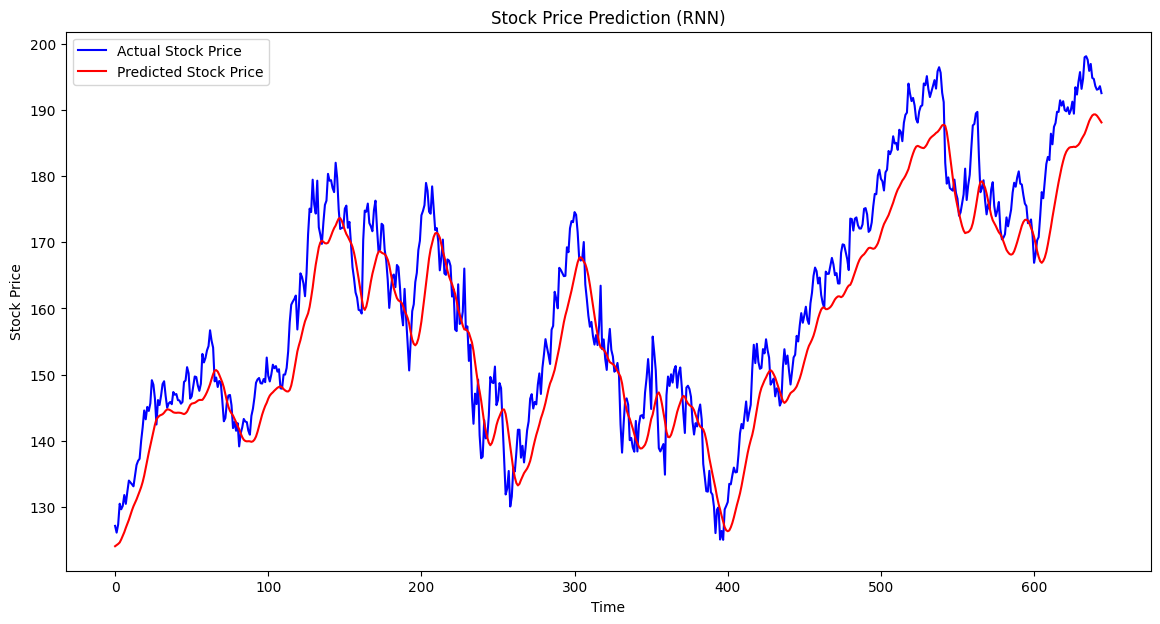

In [9]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction (RNN)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [10]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')



Mean Absolute Error: 5.392062200501908
